### <center><b>Итоговый проект: "Агенство недвижимости"</b></center>

##### <b>Описание проекта:</b> Агентство недвижимости столкнулось с проблемой: риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.  
##### <b>Бизнес-задача:</b> Повысить прибыль агентства недвижимости за счет увеличения скорости реакции риелторов и качества их работы при продаже объектов недвижимости.  
##### <b>Техническая задача для специалиста Data Science:</b> Разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок на продажу объектов недвижимости.  
##### <b>Основные цели проекта:</b>
* Произвести предобработку и разведывательный анализ набора данных:
   * обработать пропуски;
   * дубликаты и выбросы;
   * устранить ошибки ввода;
   * расшифровать сокращения;
   * отыскать закономерности;
   * сгенерировать новые признаки.
* Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.  
* Построить несколько моделей для прогнозирования стоимости недвижимости и отобрать лучшую по целевой метрике.  
* Разработать сервис, на вход которого поступали бы данные о некоторой выставленной на продажу недвижимости, а сервис прогнозировал бы ее стоимость.

In [ ]:
# Загружаем библиотеки

import pandas as pd
import numpy as np
import ast
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re
import requests
import category_encoders as ce
from scipy.stats import shapiro
from sklearn import preprocessing
from sklearn import metrics
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from catboost import CatBoostRegressor
from dmba import AIC_score, stepwise_selection
import pickle
import warnings
warnings.filterwarnings('ignore')

### <center><b>Исследование данных</b></center>

In [ ]:
# Прочитаем dataframe

df = pd.read_csv('data/data.zip')

# Знакомимся с данными

display(df.shape)
display(df.head())

##### В датасете имеется 377185 объектов, описанных следующими 18-ю признаками:
* status — статус продажи;  
* private pool и PrivatePool — наличие собственного бассейна;  
* propertyType — тип объекта недвижимости;
* street — адрес объекта;
* baths — количество ванных комнат;
* homeFacts — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* fireplace — наличие камина;
* city — город;
* schools — сведения о школах в районе;
* sqft — площадь в футах;
* zipcode — почтовый индекс;
* beds — количество спален;
* state — штат;
* stories — количество этажей;
* mls-id и MlsId — идентификатор MLS (Multiple Listing Service, система мультилистинга);
* target — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [ ]:
# Выведем информацию о датасете

df.info()

In [ ]:
# Построим тепловую карту пропусков

heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['#000099', '#ffff00'])
);
heatmap.set_title('Тепловая карта пропущенных значений');

In [ ]:
# Проверим данные на наличие дубликатов

df.duplicated().value_counts()

#### <b>Вывод:</b>
* Имеются полные дубли (50 шт.) - удалим их.
* Имеются пропуски в данных, больше всего пропущенных значений в признаках: private pool, fireplace, mls-id, PrivatePool. Необходимо будет с ними поработать.
* Все признаки представлены типом object, что тоже неправильно.
##### Дальнейшая схема работы:
1. Удалить дубли.
2. Проанализировать и удалить неинформативные признаки
3. Привести целевой признак (target) к числовому типу, и обработать пропуски в данном признаке.
4. Обработать пропуски в остальных признаках.
5. Отдельно обработать информацию в признаках homeFacts и school, содержащие пул данных.
6. Спроектировать новые признаки.
7. Визуализировать данные, найти зависимости, гипотезы.

### <center><b>Предобработка и очистка данных</b></center>

In [ ]:
# Удаляем дубли

df.drop_duplicates(inplace=True)

df.shape

##### Количество объектов сократилось на 50, ровно на количество дублей.

##### Для начала избавимся от <b><u>неинформативных признаков</u></b>
##### Признаки <b><u>MlsId</u></b> и <b><u>mls-id</u></b> являются уникальными номерами в базе данных в системе множественного листинга и никакой информативности не несут.
##### Признак <b><u>fireplace</u></b> (наличие камина) имеет порядка 90% пропусков.
##### Избавимся от этих признаков.

In [ ]:
# Удаляем неинформативные признаки

df = df.drop(['MlsId', 'mls-id', 'fireplace'], axis=1)

##### Обработаем пропуски в целевом признаке <b><u>target</u></b> и приведем его к числовому типу. Напишем функцию, которая позволит избавиться от различных символов, отличных от цифр и преобразует данные в числовой формат.

In [ ]:
# Функция-обработчик признака target

def processing_target(sign):
    number_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    # создаём новый лист, куда будем добавлять символы, если они присутствуют в number_list
    sign_new = []
    # если нет пропуска, то разбиваем посимвольно и проверяем каждый символ на соответствие number_list
    if sign is not np.nan:
        sign_list = list(str(sign))
        for i in sign_list:
            if i in number_list:
               sign_new.append(i)
        # соединяем все цифры воедино и преобразуем в числовой формат
        sign_int = int(''.join(sign_new))
        return sign_int
    # если имеется пропущенное значение, то преобразований не проводим
    else:
        return sign

In [ ]:
# Применим функцию к признаку

df['target'] = df['target'].apply(processing_target)

In [ ]:
# Посмотрим на количество пропусков в признаке target

df['target'].isnull().sum()

##### Количество пропусков в признаке target равно 2480. Это менее 1% значений, поэтому их можно просто удалить.

In [ ]:
# Удаляем строки с пропусками в целевом признаке

df.dropna(subset='target', axis=0, inplace=True)

In [ ]:
# Посмотрим на описательные статистики целевого признака

df['target'].describe()

##### Медианная стоимость недвижимости 320000$ (при средней 644759,6$, что примерно в 2 раза больше). За меру центральной тенденции примем медианное значение цены, т.к. оно устойчиво к выбросам. Также имеется недвижимость стоимостью 1$ и 195000000$, что явно является выбросами.

In [ ]:
# Посмотрим на распределение целевой переменной

fig = px.histogram(
    data_frame=df,
    x='target',    
    title='Распределение целевой переменной',
    text_auto=True,    
    height=600,    
    width=1000,
    nbins=400           
)
fig.show();

##### Распределение целевой переменной не дало понимания общей картины из-за большого диапазона цен и из-за выбросов. Избавимся от выбросов с помощью метода Тьюки, но для начала проверим на нормальность с помощью теста Шапиро-Уилка.
##### Проверим следующие гипотезы:
* $H_0$: Данные распределены нормально; 
* $H_1$: Распределение данных отлично от нормального.
##### Уровень значимости $\alpha$=0.05. 

In [ ]:
# Проверка данных на нормальность

# Нулевая и альтернативная гипотезы
H0 = 'Данные распределены нормально'
H1 = 'Распределение данных отлично от нормального'

# Уровень значимости
alpha = 0.05

# Вычисляем результат теста Шапиро — Уилка
_, p = shapiro(df['target'])

# Выводим результат на экран
print('p-value = %.3f' % p)

# Сравниваем полученное p-value с уровнем значимости
if p > alpha:
    print(f"Принимаем нулевую гипотезу: {H0}")
else:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")

##### Тест Шапиро-Уилка показал, что данные не распределены нормально. Прологарифмируем целевой признак и создадим новый признак - target_log. Тем самым приведем исходное распределение к подобию нормального.

In [ ]:
df['target_log'] = np.log(df['target'])

fig = px.histogram(
    data_frame=df,
    x='target_log',    
    title='Распределение целевой переменной',
    text_auto=True,    
    height=600,    
    width=1000, 
    nbins=400,
    marginal='box'   
)
fig.show();

##### Судя по графику, распределение данных стало похоже на нормальное. Избавимся от выбросов в целевом признаке, воспользовавшись методом Тьюки (межквартильный размах), применим его к логарифмированному целевому признаку.

In [ ]:
# Функция для реализации метода Тьюки

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)].reset_index()
    cleaned = cleaned.drop([feature, 'index'], axis=1)
    return outliers, cleaned

In [ ]:
# Применим функцию к признаку

outliers, df = outliers_iqr(df, 'target_log')

In [ ]:
# Еще раз посмотрим на описательные статистики целевого признака

df['target'].describe()

##### Значения  1$ и 195000000$ ушли. Значит мы избавились от выбров.

##### Поработаем с признаком <b><u>status</u></b>.

In [ ]:
df.status.value_counts()

In [ ]:
# Заполним пропуски самым распространённым значением. Переведём данные в нижний регистр. Оставим топ-5 значений, остальные переименуем в other

df['status'] = df['status'].fillna(df['status'].describe().top)
df['status'] = df['status'].apply(lambda x: x.lower())
status_list = list(df['status'].value_counts()[:5].index)   # лист с категориями
df['status'] = df['status'].apply(lambda x: x if x in status_list else 'other')

##### Наличие собственного бассейна содержится в 2 признаках <b><u>private pool</u></b> и <b><u>PrivatePool</u></b> объединим их в признак <b>Pool</b> и предобработаем. Если данные о наличии бассейна отсутствуют, то будем считать, что он отсутствует.

In [ ]:
# Закодируем данные в признаках 'private pool' и 'PrivatePool', если бассейн имеется '1', если нет '0'.
# Приведем признаки к числовому типу. Объединим данные признаки в признак 'Pool'

df['private pool'] = df['private pool'].fillna('0') # заполняем пустые значения '0'
df['PrivatePool'] = df['PrivatePool'].fillna('0')   # заполняем пустые значения '0'
df['private pool'] = df['private pool'].apply(lambda x: x.lower()) # преобразуем значения в нижний регистр
df['private pool'] = df['private pool'].apply(lambda x: x.replace('yes', '1')) # заменим значение 'yes' на '1'
df['private pool'] = df['private pool'].astype('int') # преобразуем данные к числовому типу
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: x.lower()) # преобразуем значения в нижний регистр
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: x.replace('yes', '1')) # заменим значение 'yes' на '1'
df['PrivatePool'] = df['PrivatePool'].astype('int') # преобразуем данные к числовому типу
df['Pool'] = df['PrivatePool'] + df['private pool'] # объединим признаки в признак 'Pool'

In [ ]:
# Удаляем признаки 'private pool' и 'PrivatePool'

df = df.drop(['private pool', 'PrivatePool'], axis=1)

Признак <b><u>propertyType</u></b> обработаем аналогично признаку <b>status</b>

In [ ]:
df.propertyType.value_counts()

In [ ]:
# Заполним пропуски самым распространённым значением. Переведём данные в нижний регистр. Оставим топ-10 значений, остальные переименуем в other

df['propertyType'] = df['propertyType'].fillna(df['propertyType'].describe().top)
df['propertyType'] = df['propertyType'].apply(lambda x: x.lower())
 
df['propertyType'] = df['propertyType'].apply(lambda x: ' '.join(x.replace('-', ' ').replace(',', ' ').replace('/', ' ').split(' ')[0:2]))       # удаляем лишние символы
df['propertyType'] = df['propertyType'].replace('condo townhome', 'condo').replace('lot land', 'land').replace('detached ', 'single detached')   # удаляем лишние символы

propertyType_list = list(df['propertyType'].value_counts()[:10].index)   # лист с категориями
propertyType_list.remove('1 story')             # удаляем неинформационную категорию '1 story'
df['propertyType'] = df['propertyType'].apply(lambda x: x if x in propertyType_list else 'other')

##### По схожей схеме обработаем признак <b><u>street</u></b>

In [ ]:
df.street.value_counts()

In [ ]:
# Заполним пропуски самым распространённым значением. Переведём данные в нижний регистр.

df['street'] = df['street'].fillna(df['street'].describe().top)
df['street'] = df['street'].apply(lambda x: x.lower())

In [ ]:
# Преобразуем признак street, оставив только наименование улиц, т.к. наименование улицы это способ привязаться к локации недвижимости

df['street'] = df['street'].replace('undisclosed address', 'not_specified').replace('(undisclosed address)', 'not_specified')\
    .replace('address not available', 'not_specified').replace('unknown address', 'not_specified').replace('address not disclosed', 'not_specified')
    
df['street'] = df['street'].apply(lambda x: ' '.join(x.split(' ')[1:4])).replace('', 'not_specified')

In [ ]:
# Улицы в единственном экземпляре объединим в категорию other

street_list = list(df['street'].value_counts()[df['street'].value_counts()==1].index)
date_street = df[df['street'].isin(street_list)]
date_street['street'] = date_street['street'].apply(lambda x: 'other')
df = pd.concat(
    [df[~df['street'].isin(street_list)], date_street],
    ignore_index=True,
    axis=0
)

##### Обработка признака <b><u>baths</u></b>.
##### Выделим строки типа object количество ванных комнат и сохраним его в формате float. Дробные значения ванных комнат, возможно ошибка а, возможно, способ закодировать не полноценную ванную комнату, скажем, с раковиной и душевой кабиной или раковиной и туалетом. Ктоме того, присутствуют и аномальные значения, которые превышают тысячи. Т.к. они имеют в остальных разрядах нули, предположим, что это опечатка, и отбросим нули. Если строка пустая, будем считать, что ванная комната отсутствует и сохраним NaN.

In [ ]:
# Функция для преобразования признака baths к числовому формату

def baths_num(sign):
    if sign is np.NaN:
        result = np.NaN # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'\d+\.*,*\d*', sign) # выделяем число ванных
        if len(result) > 0:
            result = result[0] # если оно содержалось в строке, оно - на 1-м месте списка
            result = float(result.replace(',', '')) # убираем запятую-разделитель тысяч и приводим к float
            if result >= 1000: # устраняем опечатку
                result = result / 1000
        else:
            result = np.NaN # если в строке не было числа комнтат, сохраним NaN

    return result

In [ ]:
# Применимисанную функцию

df['baths'] = df['baths'].apply(lambda sign: baths_num(sign))

##### Имеются аномалии, когда количество ванных комнат исчисляется десятками. Построим коробчатую диаграмму, чтобы посмотреть как обстоят дела с выбросами.  

In [ ]:
# Построим две коробчатые диаграмм признака baths с разбивкой на типы жилья

fig, axes = plt.subplots(figsize=(16, 5))
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    y = 'propertyType'
);
boxplot.set(xlim=(-1,20)); # ограничим диапазон
boxplot.set_title('Диаграммы числа ванных комнат по типу жилья');
boxplot.set_xlabel('Число ванных комнат');
boxplot.set_ylabel('');

##### Судя по диаграммам выбросы присутствуют. Обработаем их с помощью метода Тьюринга, но для начала проверим данные на нормальность с помощью теста Шапиро-Уилка.
##### Проверим следующие гипотезы:
* $H_0$: Данные распределены нормально; 
* $H_1$: Распределение данных отлично от нормального.
##### Уровень значимости $\alpha$=0.05. 

In [ ]:
# Проверка данных на нормальность

# Нулевая и альтернативная гипотезы
H0 = 'Данные распределены нормально'
H1 = 'Распределение данных отлично от нормального'

# Уровень значимости
alpha = 0.05

# Вычисляем результат теста Шапиро — Уилка
_, p = shapiro(df['baths'])

# Выводим результат на экран
print('p-value = %.3f' % p)

# Сравниваем полученное p-value с уровнем значимости
if p > alpha:
    print(f"Принимаем нулевую гипотезу: {H0}")
else:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")

##### Тест показал, что данные распределены нормально, следовательно, можем применить метод Тьюринга.

In [ ]:
# Воспользуемся ранее написанной функцией для определения выбросов
outliers, cleaned = outliers_iqr(df, 'baths')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print('ТОП-5 значений по количеству выбросов:',
    outliers['baths'].value_counts().nlargest(5))

##### Метод Тьюринга отнес к выбросам значения равные 0 и 5 и выше.
##### Если следовать логике, то на пустых участках ванных комнат быть не может, а именно на такой тип собственности приходится подавляющее число "нулевых" значений. Количество ванных комнат редко превышает количество спален, а их число вряд ли будет выше 10. Поэтому ориентируясь на многосемейные дома на диаграмме, посчитаем за выбросы все объекты, где число ванных комнат больше 7-ми. Проверим процент таких записей в датафрейме и, если он окажется небольшим, то удалим данные выбросы.  

In [ ]:
# Проверим количество объектов, у которых ванных больше 7-ми

baths_7 = df[df['baths'] > 7].index
display(f'> 7 ванных в {len(baths_7)} объектах')
display(' Это {:2.2%} от всего датафрейма'.format(len(baths_7)/df.shape[0]))

In [ ]:
# Т.к. это всего лишь 0.43% от всего датафрейма, удаляем эти записи

df.drop(baths_7, axis=0, inplace=True)

In [ ]:
# Выведем количество пустых значений

df.baths.isnull().sum()

##### Ранее мы приняли решение, что если строка пустая, то ванная комната отсутствует и заполняли их значением np.NaN, в принципе это возможно, т.к. на тех же пустых участках вряд ли будет присутствовать ванная комната. Но оставлять пустые значения тоже не правильно, поэтому заполним их нулями.

In [ ]:
# Заполняем пустые значения 0

df.baths = df.baths.fillna(0)

##### Признак <b><u>homeFacts</u></b> содержит несколько типов сведений, которые влияют на оценку объекта. Информация  представлена в строковом формате, который очень похож на json-формат, в котором данные хранятся в виде словарей и списков.

In [ ]:
df.homeFacts.value_counts()[:5]

##### atAGlanceFacts - основной ключь, значениями которого является список словарей.
##### В каждом словаре находятся два ключа factLabel (наименование параметра) и factValue (значение параметра). 
##### Имеются следующие параметры:
* Year built - год постройки дома;
* Remodeled year - год реконструкции;
* Heating - отопление;
* Cooling - охлаждение;
* Parking - паркинг;
* lotsize - дом с участком;
* Price/sqft - цена за квадратный фунт.
##### Необходимо создать на основе параметров новые признаки, которые впоследствии обработать.

In [ ]:
# Преобразуем строку в словарь

df['homeFacts'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x))

# Создаем новые признаки

df['year_built'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
df['remodeled_year'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
df['heating'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
df['cooling'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
df['parking'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
df['lotsize'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
df['price_sqft'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

##### Поработаем с признаком <b><u>year_built</u></b>

In [ ]:
# Выведем информация о пропущенных значениях

df.year_built.isnull().sum()

In [ ]:
# Преобразуем признак в числовой формат, заменим ненужные значения на NaN, заполним пропуски медианным значением
# Также заменим на медианные значения года постройки позже 2023 года и раньше 1700 года

df['year_built'] = df['year_built'].apply(lambda x: np.nan if x == '' else np.nan if x == 'No Data' else np.nan if x is None else x)
df['year_built'] = df['year_built'].fillna(df['year_built'].median())
df['year_built'] = df['year_built'].apply(lambda x: int(x))
df['year_built'] = df['year_built'].apply(lambda x: df['year_built'].median() if x > 2023 else df['year_built'].median() if x < 1700 else x)

In [ ]:
# Проверим, что у нас получилось

df.year_built.describe()

In [ ]:
# Создадим новый признак age (возраст дома), т.е. разница между текущим годом и годоь постройки

year_current = datetime.datetime.now().year   # текущий год
df['age'] = year_current - df['year_built']

##### Признак <b><u>remodeled_year</u></b>

In [ ]:
# Выведем информация о пропущенных значениях

df['remodeled_year'].isnull().sum()

In [ ]:
# Преобразуем признак в числовой формат, заменим ненужные значения на NaN, заполним пропуски медианным значением

df['remodeled_year'] = df['remodeled_year'].apply(lambda x: np.nan if (x == '') | (x == None) else x)
df['remodeled_year'] = df['remodeled_year'].fillna(df['remodeled_year'].median())
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: int(x))

In [ ]:
# Создадим признак age_remodeled - сколько лет прошло с реконструкции дома
# Если в признаке remodeled_year указан 0, то время реставрации считается с даты постройки дома

df['age_remodeled'] = df.apply(lambda x: (year_current - x.remodeled_year) if x.remodeled_year != 0 else (year_current - x.year_built), axis=1)

In [ ]:
# Удаляем ненужные более признаки year_built и remodeled_year

df = df.drop(['year_built', 'remodeled_year'], axis=1)

##### Признак <b><u>heating</u></b>

In [ ]:
# Выведем количество пропусков

df['heating'].isnull().sum()

In [ ]:
# Переведем значения в нижний регистр, уберем лишние символы, возьмём только первые два значения

df['heating'] = df['heating'].apply(lambda x: x.lower() if (type(x) is not float) and (x is not None) else x)
df['heating'] = df['heating'].apply(lambda x: np.nan if (x is None) | (x == '') else x)
df['heating'] = df['heating'].apply(lambda x: x.replace(',', '') if type(x) is not float else x)
df['heating'] = df['heating'].apply(lambda x: x if (x is np.nan) | (type(x) is float) else ' '.join(x.split(' ')[:2]))

##### Будем считать, что на объектах где в значении heating указано 'no data' или 'none', отопление отсутствует, что в США с учетом их температурного режима возможно.

In [ ]:
# Преобразуем значения, после чего отберём 9 популярных значений, а остальные заменим на other
# Пропущенные значения заменим самой распространённой категорией

df['heating'] = df['heating'].replace('central electric', 'electric').replace(' electric', 'electric').replace('no data', 'absent').replace('electric heat', 'electric')\
    .replace('natural gas', 'gas').replace(' gas', 'gas').replace('central gas', 'gas').replace('gas heat', 'gas').replace('electric gas', 'gas').replace('gas hot', 'gas')\
        .replace('gas -', 'gas').replace('propane', 'gas').replace(' heat', 'heat pump').replace('heating system', 'central').replace('central furnace', 'central')\
            .replace('central heating', 'central').replace('central heat', 'central').replace('heat pump(s)', 'heat pump').replace('radiant', 'central').replace('baseboard forced', 'baseboard')\
                .replace('baseboard hot', 'baseboard').replace('none', 'absent')

df['heating'] = df['heating'].fillna(df['heating'].describe().top)

heating_list = list(df['heating'].value_counts()[:9].index)    # топ 9 категорий

df['heating'] = df['heating'].apply(lambda x: x if x is np.nan else x if x in heating_list else 'other')

In [ ]:
# Посмотрим, что получилось

df['heating'].value_counts()

##### Признак <b><u>cooling</u></b>

In [ ]:
# Выведем количество пропусков

df['cooling'].isnull().sum()

In [ ]:
# Переведем значения в нижний регистр, проведем преобразования

df['cooling'] = df['cooling'].apply(lambda x: x.lower() if (x is not np.nan) & (x is not None) else x)
df['cooling'] = df['cooling'].apply(lambda x: np.nan if (x is None) | (x == 'none') | (x == '') else x)

In [ ]:
# Выведем 40 распространённых значений

df['cooling'].value_counts()[:40]

##### Будем действовать по аналогии с признаком <i>heating</i>, если где в значении cooling указано 'no data' или 'none', будем считать, что кондиционирование отсутствует (значение 'absent').

In [ ]:
# Преобразуем значения и разделим на категории. После чего отберём 9 популярных значений, а остальные заменим на other
# Пропущенные значения заменим самой распространённой категорией

df['cooling'] = df['cooling'].replace('no data', 'absent').replace('none', 'absent')
df['cooling'] = df['cooling'].apply(lambda x: x if x is np.nan else ' '.join(x.split(' ')[:2]))
df['cooling'] = df['cooling'].apply(lambda x: x.replace(',', '') if type(x) is not float else x)
df['cooling'] = df['cooling'].replace('has cooling', 'cooling').replace('central a/c', 'central air')

df['cooling'] = df['cooling'].fillna(df['cooling'].describe().top)

cooling_list = list(df['cooling'].value_counts()[:9].index)    # топ-9 значений

df['cooling'] = df['cooling'].apply(lambda x: x if x is np.nan else x if x in cooling_list else 'other')

In [ ]:
# Посмотрим, что получилось

df['cooling'].value_counts()

##### Признак <b><u>parking</u></b>

In [ ]:
# Выведем количество пропусков

df['parking'].isnull().sum()

In [ ]:
# Выведем 20 распространенных значений

df['parking'].value_counts()[:20]

##### Произведём преобразование признака и унификацию категорий, если в значении указано 'no data' или 'none', будем считать, что парковка отсутствует (значение '0'), далее оставим топ-15, остальное обозначим как other, пропуски заполним топовым значением.

In [ ]:
# Переведем значения в нижний регистр, проведем преобразования
# После чего отберём 15 популярных значений, а остальные заменим на other
# Пропущенные значения заменим самой распространённой категорией

df['parking'] = df['parking'].apply(lambda x: x.lower() if (x is not np.nan) & (x is not None) else x)
df['parking'] = df['parking'].apply(lambda x: np.nan if (x is None) | (x == '') else x)
df['parking'] = df['parking'].replace('no data', '0').replace('none', '0')
df['parking'] = df['parking'].apply(lambda x: x if x is np.nan else x.replace('+', '').replace(',', '').split(' ')[0])
df['parking'] = df['parking'].replace('driveway', 'off').replace('garage', 'detached')

df['parking'] = df['parking'].fillna(df['parking'].describe().top)

parking_list = list(df['parking'].value_counts()[:15].index)    # топ лист

df['parking'] = df['parking'].apply(lambda x: x if x is np.nan else x if x in parking_list else 'other')

In [ ]:
# Посмотрим, что получилось

df['parking'].value_counts()

##### Признак <b><u>lotsize</u></b>

In [ ]:
# Выведем количество пропусков

df['lotsize'].isnull().sum()

In [ ]:
# Выведем 20 распространенных значений

df['lotsize'].value_counts()[:20]

##### Значения в разных единицах измерения - акры (acres) и квадратные фунты (sqft) - переведём всё к одному виду - sqft.

In [ ]:
# Функция для перевода акры в фунты

def acr_change(acr):
    sqft = 43560 * float(acr)
    return sqft

In [ ]:
# Функция-обработчик признака lotsize

def handler_lotsize(df):
    # заменяем пропуски на No и приводим разделитель к общему виду - точки
    df = df.replace('—', 'No').replace('No Data', 'No').replace('-- sqft lot', 'No').replace(',', '')
    
    if df != 'No':
        # приводим строку к нижнему регистру
        df = df.lower()
        # создаём лист со значениями 
        list_temp = df.split(' ')
        # если строка состоит из более чем одного значения, и второе значение 'acres' или 'acre', то переводим в кв фунты
        if (len(list_temp) > 1) and (df.split(' ')[1] == 'acres' or df.split(' ')[1] == 'acre'):
            df = acr_change(list_temp[0])
            return df
        else:
            df = float(list_temp[0])
            return df
    return df

In [ ]:
# Меняем все пропущенные значения для удобства на No

df['lotsize'] = df['lotsize'].apply(lambda x: 'No' if (x is np.nan) | (x is None) | (x == '') else x)

# Применяем функцию-обработчик

df['lotsize'] = df['lotsize'].apply(handler_lotsize)

# Все No меняем на np.nan, отрицательные значения на 0

df['lotsize'] = df['lotsize'].apply(lambda x: np.nan if x == 'No' else 0 if x < 0 else x)

# Пропуски заменяем на медианное значение

df['lotsize'] = df['lotsize'].fillna(df['lotsize'].describe().median())

##### Признак <b><u>price_sqft</u></b>

In [ ]:
# Выведем количество пропусков

df['price_sqft'].isnull().sum()

In [ ]:
# Выведем 20 распространенных значений

df['price_sqft'].value_counts()[:20]

##### В признаке имеются явные пропуски значений и не явные в виде записей 'No Data' и 'No Info', которые заменим на np.nan.

In [ ]:
# Заменяем ненужные значения и символы. Пропуски заменяем на медианное значение

df['price_sqft'] = df['price_sqft'].apply(lambda x: np.nan if (x == 'No Data') | (x == 'No Info') | (x is None) | (x == '') else x)
df['price_sqft'] = df['price_sqft'].apply(lambda x: x if x is np.nan else float(x.replace('$', '').replace('/', ' ').replace(',', '').split(' ')[0]))
df['price_sqft'] = df['price_sqft'].fillna(df['price_sqft'].median())

##### После того как разобрались с признаком homeFacts его можно удалить

In [ ]:
# Удаляем признак homeFacts

df = df.drop(['homeFacts'], axis=1)

##### Обработка признака <b><u>city</u></b>:
* заменим пустые строки, а также значения "other" на названия городов, для этого воспользуемся признаком почтового кода zipcode;
* разделим написание city с именем города, например, commercecity;
* заменим распространенные сокращения на полные назания;

  - [X] st -> saint
  - [X] pt -> port
  - [X] ft -> fort
  - [X] mt -> mount
  - [X] twp -> township

* заменим сокращенные названия городов на полные.

In [ ]:
# Удалим строки с пропусками

df.dropna(subset='city', axis=0, inplace=True)

In [ ]:
# Приводим к нижему регистру

df['city'] = df['city'].str.lower()

In [ ]:
# Обработка пустых названий и other  
# Создадим датафрейм для подбора подходящего названия города по индексу

zip_city_df = df.groupby(['zipcode', 'city'])['city'].count()

# Отберем все города, где вместо названия содержится слово other

ind = []
ind.extend(df[df['city'].str.contains('other') == True].index)
ind.extend(df[df['city'] == ' '].index)

# Заменим на наиболее подходящее название города

df.loc[ind, 'city']\
= df.loc[ind, ['zipcode']]\
.applymap(lambda x: zip_city_df[x].sort_values(ascending=False).index[0]).squeeze()

# Если не удалось подобрать название города по индексу - оставим other, чтобы не терять данные

ind = df[df['city'].str.contains('other') == True].index
df.loc[ind, 'city'] = 'other'

In [ ]:
# Отберем все города, где слово city написано слитно

ind = df[df['city'].str.contains(r'\wcity') == True].index

# Заменим на наиболее подходящее название города

p = re.compile('(\w+)city') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: p.findall(x)[0] + ' city').squeeze()


In [ ]:
# Отберем все города, где вначале написано st или st.

ind = df[df['city'].str.match('(st\.*)\s+') == True].index

# Заменим на наиболее подходящее название города

p = re.compile('(st\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'saint ' + x[p.match(x).end():]).squeeze()

In [ ]:
# Отберем все города, где есть сокращение pt/pt.

ind = df[df['city'].str.match('(pt\.*)\s+', case=False) == True].index

# Заменим на развернутое port

p = re.compile('(pt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'port ' + x[p.match(x).end():]).squeeze()

In [ ]:
# Отберем все города, где есть сокращение ft/ft.

ind = df[df['city'].str.match('(ft\.*)\s+', case=False) == True].index

# Заменим на развернутое fort

p = re.compile('(ft\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'fort ' + x[p.match(x).end():]).squeeze()

In [ ]:
# Отберем все города, где есть сокращение mt/mt.

ind = df[df['city'].str.match('(mt\.*)\s+', case=False) == True].index

# Заменим на развернутое mount

p = re.compile('(mt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'mount ' + x[p.match(x).end():]).squeeze()

In [ ]:
# Отберем все города, где есть сокращение twp/twp.

ind = df[df['city'].str.contains('\s+(twp\.?)', case=False) == True].index

# Заменим на развернутое township

p = re.compile('\s+(twp\.?)') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: x[:p.search(x).start()] + ' township').squeeze()

In [ ]:
# Заменим сокращенные названия городов на полные

df.loc[df[df['city'] == 'new york city'].index, 'city'] = 'new york'
df.loc[df[df['city'] == 'e. new york'].index, 'city'] = 'brooklyn'
df.loc[df[df['city'] == 'point charlotte'].index, 'city'] = 'port charlotte'
df.loc[df[df['city'] == 'p c beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'west panama city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'piney pt village'].index, 'city'] = 'piney point village'
df.loc[df[df['city'] == 'city center'].index, 'city'] = 'las vegas'
df.loc[df[df['city'] == 'pete beach'].index, 'city'] = 'saint pete beach'
df.loc[df[df['city'] == 'atlaanta'].index, 'city'] = 'atlanta'
df.loc[df[df['city'] == 'n miami beach'].index, 'city'] = 'miami beach'

In [ ]:
# Т.К. признак zipcode более не нужен, удаляем его

df.drop('zipcode', axis=1, inplace=True)

##### Признак <b><u>schools</u></b> по структуре похож на формат json файла с вложенными словарями и списками, в которых содержатся следующие данные:
* rating - рейтинг школ
* data, содержащий несколько сведений:

    - Distance - дистанции до школ, в милях;
    - Grades - уровень школы (младшая/средняя/старшая/и тд);
    - name - наименование школы.

##### Для нас интересны только <u>rating</u> и <u>Distance</u>, остальные проигнорируем.
##### Для начала преобразуем строковое значение в словарь и создадим два новых признака <u>rating</u> и <u>distance</u>

In [ ]:
# Создаем новые признаки и удаляем признак school

df['rating'] = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['rating'])
df['distance'] = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['data']['Distance'])
df = df.drop(['schools'], axis=1)

##### Значение признака <b><u>rating</u></b> представлено в виде списка рейтингов школ в данном районе. Список может быть либо пустым, либо содержать 'NR' (нет рейтинга) и 'NA' (нет данных). Создадим на основе данного признака новый признак <b><u>rating_school</u></b> - среднее значение рейтинга школ в данном районе. 

In [ ]:
# Функция обработчик признака raiting

def rating_mean(sign):
    temp_list = []
    list_rating = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    
    if sign == []:
        return np.nan
    else:
        for i in sign:
            i = i.split('/')[0]
            if i in list_rating:
                temp_list.append(float(i))
        sign_mean = round(np.mean(temp_list), 2)
        return sign_mean   

In [ ]:
# Применяем функцию-обработчик к признаку, пустые значения заполняем средним
# Удаляем признак reiting 

df['rating_school'] = df['rating'].apply(rating_mean)
df['rating_school'] = df['rating_school'].fillna(round(df['rating_school'].mean(), 2))
df = df.drop(['rating'], axis=1)                                                           

##### Признак <b><u>distance</u></b> представлен в виде списка из расстояний до школ. Создадим на его основе два новых признака: <b><u>distance_school</u></b> (среднее расстояние до школы) и <b><u>schools_count</u></b> (количество школ в данном районе).

In [ ]:
# Функция обработчик признака distance

def distance_mean(sign):
    temp_list = []
    
    for i in sign:
        i = i.split('mi')[0]
        temp_list.append(float(i))
    dist_mean = round(np.mean(temp_list), 2)
    schools_count = len(temp_list)
    return [dist_mean, schools_count]

In [ ]:
# Применяем функцию-обработчик к признаку и создаем новые признаки
# В признаке school_count нулевые значения заполняем медианой
# В признаке distance_school пустые значения заполняем средним
# Удаляем признак distance

df['distance_school'] = df['distance'].apply(lambda x: distance_mean(x)[0])
df['schools_count'] = df['distance'].apply(lambda x: distance_mean(x)[1])
df['schools_count'] = df['schools_count'].apply(lambda x: df['schools_count'].median() if x==0 else x)
df['distance_school'] = df['distance_school'].fillna(round(df['distance_school'].mean(), 2))                                                 
df = df.drop(['distance'], axis=1)

##### В признаке <b><u>sqft</u></b> имеются записи в следующих форматов: '--', '2500 sqft', '-- sqft', 'Total interior livable area: 2,533 sqft' и т.д. Кроме того имеются пропущенные значения. Напишем функцию-обработчик, которая удалит лишние символы и приведет значения к единому числовому формату. Пропущенные значения заменим медианой.

In [ ]:
df['sqft'].value_counts()[:20]

In [ ]:
# Функция-обработчик для признака sqft

def sqft_num(sign):
    if sign is np.nan or sign == '--' or sign.replace(',', '').split(' ')[0]=='--':
        return np.nan
    if sign.replace(',', '').split(' ')[0].lower()=='total':
        sign = float(sign.replace(',', '').split(' ')[-2])
    else:
        sign = float(sign.replace(',', '').split(' ')[0])        
    return sign

In [ ]:
# Применим функцию
# Пропущенные значения заменим медианой

df['sqft'] = df['sqft'].apply(sqft_num)
df['sqft'] = df['sqft'].fillna(df['sqft'].median())

In [ ]:
# Выведем описательные статистики признака

df.sqft.describe()

##### Удалось привести к единому числовому формату. Про выбросы в данном признаке говорить сложно, т.к. площадь можетбыть любой, кроме отрицательной конечно, которую мы и не наблюдаем.

##### Обработка признака <b><u>beds</u></b> - количество спален

##### Признак <b><u>beds</u></b> содержит количество спальных комнат либо в виде числа, либо в формате "`n` Beds/bd", где `n` - число спален. Встречаются и пустые записи, а также записи, в которых вместо количества спален записана площадь в квадратных футах или акрах, которые нас не интересуют.

In [ ]:
# Функция для выделения числа спален

def beds_num(s):
    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    elif s.isdigit():
        result = s # если в строке только число спален без точки, оставляем строку
    else:
        result = re.findall(r'(\d+)\s+[Bb]ed', s) # выделяем число спален из формата 10 Beds
        if len(result) > 0:
            result = result[0]
        else:
            result = re.findall(r'(\d+)\.*\d*\s+bd', s) # выделяем число спален из формата 3.0 bd
            if len(result) > 0:
                result = result[0]
            else:
                result = re.findall(r'(\d+)\.', s) # выделяем число спален из формата 10.0
                if len(result) > 0:
                    result = result[0]
                else:
                    result = np.NaN # если спален нет, а только текст, то - np.NaN

    # Возвращаем число спален в формате float
    return float(result)

In [ ]:
# Применяем написанную функцию для выделения числа спален

df['beds'] = df['beds'].apply(beds_num)

##### Проверим, что данные распределены нормально с помощью теста Шапиро-Уилка.
##### Проверим следующие гипотезы:
* $H_0$: Данные распределены нормально; 
* $H_1$: Распределение данных отлично от нормального.
##### Уровень значимости $\alpha$=0.05. 

In [ ]:
# Проверка данных на нормальность

# Нулевая и альтернативная гипотезы
H0 = 'Данные распределены нормально'
H1 = 'Распределение данных отлично от нормального'

# Уровень значимости
alpha = 0.05

# Вычисляем результат теста Шапиро — Уилка
_, p = shapiro(df['beds'])

# Выводим результат на экран
print('p-value = %.3f' % p)

# Сравниваем полученное p-value с уровнем значимости
if p > alpha:
    print(f"Принимаем нулевую гипотезу: {H0}")
else:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")

##### Воспользуемся методом Тьюки, чтобы выявить выбросы в данных.

In [ ]:
# Воспользуемся ранее написанной функцией для определения выбросов
outliers, cleaned = outliers_iqr(df, 'beds')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print('ТОП-5 значений по количеству выбросов:',
    outliers['beds'].value_counts().nlargest(5))

##### Метод Тьюки отнес к выбросам ноль спален, одну спальню, а также свыше 5.
##### Можно предположить, что число спален находится в некоей зависимости от числа ванных комнат, т.е. число ванных комнат редко превышает число спален. Проверим предположение, вычислив отношение и взяв медиану.   

In [ ]:
print('Отношение числа спален к числу ванных:', (df.beds / df.baths).median().round(2))

##### Предположение подтвердилось. Имея обработанный признак "baths" мы можем сверяться с вычисленным значением "beds".  Спальни отсутствуют на пустых участках, 1 спальня вполне может быть в недорогом односемейном доме. Посколько для ванных мы ограничили данные чилом 7, следовательно спален в таком случае может быть: `7 * 1.33 = 9.31`. Округлим до 9. Тогда будем считать выбросами все записи, в которых число спален превышает 9. 

In [ ]:
# Проверим количество объектов, у которых спален больше 9

beds_9 = df[df['beds'] > 9].index
print(f'Свыше 9 спален насчитывается в {len(beds_9)} объектах')
print('Это составляет {:2.2%} всего датафрейма'.format(len(beds_9)/df.shape[0]))

In [ ]:
# Удаляем эти записи

df.drop(beds_9, axis=0, inplace=True)

##### Заполним пропуски в данных медианным значением

In [ ]:
# Заполним пропуски медианным значением

df.beds = df.beds.fillna(df.beds.median())  

##### Признак <b><u>state</u></b>

##### В признаке <b><u>state</u></b> обнаружились несуществующие аббревиатуры штатов. Соберем их в таблицу с количеством записей и способом устранения ошибки.

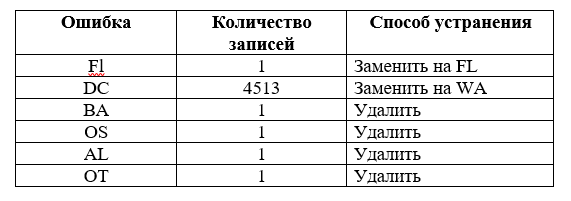

In [ ]:
# Заменим неверные аббревиатуры шатов

df.loc[df[df['state'] == 'Fl'].index, 'state'] = 'FL'
df.loc[df[df['state'] == 'DC'].index, 'state'] = 'WA'

# По остальным сохраним индекс и удалим записи по индексам

ind = []
ind.extend(df[df['state'] == 'BA'].index)
ind.extend(df[df['state'] == 'OS'].index)
ind.extend(df[df['state'] == 'AL'].index)
ind.extend(df[df['state'] == 'OT'].index)
df.drop(ind, axis=0, inplace=True)

##### В признаке <b><u>stories</u></b> записи представлены в строковом формате, некоторые прописаны словами ('One', 'One,' '1 Story'), некоторые числами. Имеются пропущенные значения и специальные символы, например, '+'. Имеются записи не имеющие никакого отношения к этажности т.е. неинформативные. Напишем функцию-обработчик признака stories, с помощью которой приведем значения этажности к единому числовому формату. Пропущенные и неинформативные значения заполним медианой.

In [ ]:
df['stories'].value_counts()[:25]

In [ ]:
# Функция обработчик признака stories

def stories_num(sign):
    # словарь для замены номеров этажей
    stories_dict = {'One':1, 'Two':2, 'Three':3, 'Tri-Level':3, 'One,':1, '1-2':1.5, 'Bi-Level':2, '3-4':3.5, 'Two,':2, 'Tri':3}
    
    if sign is not np.nan:
        sign = sign.replace('+', '').split(' ')[0]
        if sign in stories_dict.keys():
            sign = stories_dict[sign]
            try:
                sign = float(sign)
                return sign
            except ValueError:
                sign = np.nan
                return sign
        else:
            try:
                sign = float(sign)
                return sign
            except ValueError:
                sign = np.nan
                return sign
    else:
        return sign

In [ ]:
# Применяем функцию

df['stories'] = df['stories'].apply(stories_num)

In [ ]:
df['stories'].value_counts()

In [ ]:
df[df['stories'] > 100]

##### Число этажей может быть любым, кроме отрицательного конечно, но такие значения отсутствуют. Тем не менее есть два объекта с этажностью более 100, явно это выбросы. Избавимся от них.

In [ ]:
df = df[df['stories'] < 100].reset_index().drop(['index'], axis=1)

In [ ]:
# Заполним пропуски медианой

df['stories'] = df['stories'].fillna(df['stories'].median())

#### Вывод:
##### Итак, мы закончили предобработку данных. В процессе нее сделали следующее:
* удалили неинформативные признаки;
* привели числовые данные к числовому типу;
* разобрались с выбросами;
* создали новые признаки.

In [ ]:
# Выведем информацию о данных после очистки

df.info()

##### <center><b>EDA анализ данных</b></center>

##### В очищенном датасете осталось 213850 наблюдений. Выведем информацию о распределении целевой переменной.

In [ ]:
fig = px.histogram(
    data_frame=df,
    x='target',    
    title='Распределение признака target',
    text_auto=True,    
    height=800,    
    width=1500,
    marginal='box'     
)
fig.show();

In [ ]:
# Выведем информации об асиметрия распределения данных
 
print(f"Значение асимметрии равно:  {df['target'].skew().round(2)}")

##### Распределение целевой переменной имеет визуально читаемый вид. Признак асиметричный - коэффициент асиметрии положительный и равен 2.73. Это говорит о смещении вправо. На графике наблюдаем длинный правый хвост, в котором имеются наблюдения с большим диапазоном разброса цен:
* Медианное значение 325000$
* Среднее - 462330$
* Минимальное - 34251$
* Максимальное - 3195000$

##### Попытаемся найти зависимости в признаках и сформировать гипотезы/выводы.
##### Зависимость целевого признака <b>target</b> от признака <b>status</b>.

In [ ]:
# Распределение признака status

fig = px.histogram(
    data_frame=df.groupby(['status'], as_index=False)['target'].count(),
    x='status',
    y= ['target'],
    color='status',
    height=500, 
    width=1000, 
    title='Распределение признака status',
    text_auto=True   
)

fig.show();

##### Основная масса недвижимости со статусом for sale, наименьшее количество со статусом foreclosure.

In [ ]:
# Зависимость медианного значения целевой переменной от status

fig = px.bar(
    data_frame= df.groupby(['status'], as_index=False)['target'].median(),
    x='status',
    y='target',
    color='status',
    text='target', 
    orientation='v',
    title='Зависимость медианного значения признака target от признака status',
    height=500, 
    width=1000   
)

fig.show();

##### Медианная стоимость недвижимости в зависимости от статуса распределена следующим образом: наибольшая зафиксирована в категории new construction, наименьшая в категории foreclosure. Что касается категорий active и for sale, то судя по графику разницы в распределении цен практически нет. Чтобы подтвердить это проведем статистические тесты. Например, критерий Краскела-Уоллиса.
##### Проверим следующие гипотезы:
* $H_0$: Нет статистически значимой разницы между ценой недвижимости с разным статусом продажи; 
* $H_1$: Есть статистически значимая разница между ценой недвижимости с разным статусом продажи.
##### Уровень значимости $\alpha$=0.05.

In [ ]:
# Сгруппируем данные по признаку status

for_sale = df[df['status']=='for sale']['target'].values
active = df[df['status']=='active']['target'].values
foreclosure = df[df['status']=='foreclosure']['target'].values
new_construction = df[df['status']=='new construction']['target'].values
pending = df[df['status']=='pending']['target'].values
other = df[df['status']=='other']['target'].values

In [ ]:
# Критерий Краскела-Уоллиса

from scipy import stats

# Нулевая и альтернативная гипотезы
H0 = 'Нет статистически значимой разницы между ценой недвижимости с разным статусом продажи'
H1 = 'Есть статистически значимая разница между ценой недвижимости с разным статусом продажи'

# Уровень значимости
alpha = 0.05

# Вычисляем результат
_, p = stats.kruskal(for_sale, active, foreclosure, new_construction, pending, other)

# Выводим результат на экран
print('p-value = %.3f' % p)

# Сравниваем полученное p-value с уровнем значимости
if p > alpha:
    print(f"Принимаем нулевую гипотезу: {H0}")
else:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")

##### Т.к. результат теста Краскела-Уоллиса показал, что статистическая значимость между ценой недвижимости с разным сатусом продажи есть, целесообразно провести тест Данна, чтобы точно определить, какие именно статусы отличаются.

In [ ]:
# Тест Данна

import scikit_posthocs as sp

data = [for_sale, active, foreclosure, new_construction, pending, other]
sp.posthoc_dunn (data, p_adjust = 'bonferroni')[sp.posthoc_dunn (data, p_adjust = 'bonferroni') < 0.05]

##### Критерий Краскела-Уоллиса и тест Данна доказали, что существует статистически значимая разница между ценой недвижимости с разным значением признака status.

##### Зависимость целевого признака <b>target</b> от <b>propertyType</b>

In [ ]:
# Распределение признака propertyType

fig = px.histogram(
    data_frame=df.groupby(['propertyType'], as_index=False)['target'].count().sort_values(by=['target'], ascending=False),
    x='propertyType',
    y= ['target'],
    color='propertyType',
    height=500, 
    width=1000, 
    title='Распределение признака propertyType',
    text_auto=True   
)

fig.show();

##### Около 70 % объявлений о продаже недвижимости приходится на категорию single family, Наименьшее количество на категории single detached.

In [ ]:
# Зависимость медианного значения целевой переменной от propertyType

fig = px.bar(
    data_frame= df.groupby(['propertyType'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x='propertyType',
    y='target',
    color='propertyType',
    text='target', 
    orientation='v',
    title='Зависимость медианного значения признака target от признака propertyType',
    height=500, 
    width=1000   
)

fig.show();

##### Видим, что признак single detached существенно влияет на цену недвижимости, наименьшее влияние, судя по графику оказывают признаки land и high rise, хотя это скорее всего обусловлено количеством объявлений 13 и 3. Что касается категорий single family, condo, other и townhouse, то судя по графику разницы в распределении цен практически нет. Чтобы подтвердить это проведем статистический тест.
##### Проверим следующие гипотезы:
* $H_0$: Нет статистически значимой разницы между ценой разного типа недвижимости; 
* $H_1$: Есть статистически значимая разница между  ценой разного типа недвижимости.
##### Уровень значимости $\alpha$=0.05.

In [ ]:
# Сгруппируем данные по признаку propertyType

single_detached = df[df['propertyType']=='single detached']['target'].values
multi_family = df[df['propertyType']=='multi family']['target'].values
coop = df[df['propertyType']=='coop']['target'].values
propertyType = df[df['propertyType']=='single family']['target'].values
condo = df[df['propertyType']=='condo']['target'].values
other = df[df['propertyType']=='other']['target'].values
townhouse = df[df['propertyType']=='townhouse']['target'].values
traditional = df[df['propertyType']=='traditional']['target'].values
land = df[df['propertyType']=='land']['target'].values
high_rise = df[df['propertyType']=='high rise']['target'].values

In [ ]:
# Критерий Краскела-Уоллиса

# Нулевая и альтернативная гипотезы
H0 = 'Нет статистически значимой разницы между ценой разного типа недвижимости'
H1 = 'Есть статистически значимая разница между ценой разного типа недвижимости'

# Уровень значимости
alpha = 0.05

# Вычисляем результат
_, p = stats.kruskal(single_detached, multi_family, coop, propertyType, condo, other, townhouse, traditional, land, high_rise)

# Выводим результат на экран
print('p-value = %.3f' % p)

# Сравниваем полученное p-value с уровнем значимости
if p > alpha:
    print(f"Принимаем нулевую гипотезу: {H0}")
else:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")

##### Критерий Краскела-Уоллиса показал, что существует статистически значимая разница между ценой разного типа недвижимости.

##### Зависимость целевого признака <b>target</b> от признака <b>state</b>

In [ ]:
# Распределение объявлений по штатам

fig = px.histogram(
    data_frame=df.groupby(['state'], as_index=False)['target'].count().sort_values(by=['target'], ascending=False),
    x='state',
    y= ['target'],
    color='state',
    height=500, 
    width=1000, 
    title='Распределение признака state',
    text_auto=True   
)

fig.show();

##### На графике представлены данные по 30 штатам, болше всего предложиний в штате Техас (TX) 59582 и штате Флорида (FL) 57907, наименьшие значения в штатах Оклахома (OK), Южная Калифорния (SC), Кентукки (KY) и Делавэр (DE) - 30, 12, 4 и 4 соответственно.

In [ ]:
# Зависимость медианного значения целевой переменной от state

fig = px.bar(
    data_frame= df.groupby(['state'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x='state',
    y='target',
    color='state',
    text='target', 
    orientation='v',
    title='Зависимость медианного значения признака target от признака state',
    height=500, 
    width=1000   
)

fig.show();

##### По поводу медианной цены на недвижимость, то в лидерах штаты:
* Калифорния (CA) - 650000$;
* Массачусетс (MA) - 639000$;
* Нью-Йорк (NY) - 618000$;
* Вашингтон (WA) - 509000$;
* Орегон (OR) - 469000$.
##### Наименьшая стоимость:
* Миссури (MO) - 180000$;
* Огайо (OH) - 150000$;
* Оклахома (OK) - 124450$;
* Мичиган (MI) - 114900;
* Айова (IA) - 112500.
##### Можно предположить, что данный признак оказывает влияние на цену недвижимости.

##### Зависимость целевого признака <b>target</b> от признака <b>city</b>

In [ ]:
# Зависимость медианного значения target от city

treemap_data = df.groupby(by='city', as_index=False)[['target']].median().sort_values(by=['target'], ascending=False)[:101]

#строим график
fig = px.treemap(
    data_frame=treemap_data, #DataFrame
    path=['city'], #категориальный признак, для которого строится график
    values='target', #параметр, который сравнивается
    height=500, #высота
    width=1500, #ширина
    title='Зависимость медианного значения признака target от признака city' #заголовок    
)

#отображаем график
fig.show();

##### Топ-городов по цене недвижимости:
* Saratoga (штат Калифорния) - 2998000$;
* New Richmond (штат Огайо) - 2980000$;
* Sunset Beach (штат Серерная Каролина) - 2822500$;
* Friendswood (штат Техас) - 2750250$;
* Rancho Park (штат Калифорния) - 2750000$.
##### Наименьшая стоимость:
* Dixie - 1140000$;
* Coral gables - 1049000$;
* Fremont - 1024880$;
* Romayor - 999500$;
* Woodland hills - 999500$.
##### Также можно предположить о влиянии данного признака на стоимость недвижимости.

##### Зависимость целевого признака <b>target</b> от <b>beds</b>

In [ ]:
# Распределение признака beds

fig = px.histogram(
    data_frame=df,
    x='beds',    
    title='Распределение beds',
    text_auto=True,    
    height=500,    
    width=1000      
)
fig.show();

##### По количеству спален объявления о продаже недвижимости располагаются следующим образом:
* 3 beds - 104300;
* 4 beds - 52805;
* 2 beds - 32410.
##### На последнем месте по количеству объявалений 9 beds - 179.
##### Основная доля объектов приходится на количество beds от 2 до 5.

In [ ]:
# Диаграмма рассеивания зависимости медианного значения target от beds

fig = px.scatter(
    data_frame=df.groupby(['beds'], as_index=False)['target'].median(),
    x='beds',   
    y='target',
    color='beds',
    title='Диаграмма рассеивания median target от beds',       
    height=500,    
    width=1000,
    size='target'       
)
fig.show();

##### Вдна зависимость цены недвижимости от числа beds. До трёх включительно разница небольшая, но после трёх видно ускорение в увеличении стоимости. Особенно заметен скачок после 4 beds до 7.  С 7 до 9 beds разница опять несущественна. Возможно это связано с небольшой разницей в общей площади дома и более меньшими площадями самих beds.

##### Зависимость целевого признака <b>target</b> от признака <b>baths</b>

In [ ]:
# Распределение baths 

fig = px.histogram(
    data_frame=df,
    x='baths',    
    title='Распределение baths',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=20     
)
fig.show();

##### По количеству ванных комнат (baths) объявления следующим образом:
* 2 (1.75 - 2.24) baths - 74476;
* 3 (2.75 - 3.24) baths - 50282;
* 0 (0 - 0.24) baths - 29140.
##### На последнем месте по количеству объявалений попал диапазон (6.25 - 6.74) baths - 104.
##### Основная доля объектов приходится на количество baths от 2 до 4.

In [ ]:
# Диаграмма рассеивания зависимости медианного значения target от baths

fig = px.scatter(
    data_frame=df.groupby(['baths'], as_index=False)['target'].median(),
    x='baths',   
    y='target',
    color='baths',
    title='Диаграмма рассеивания median target от baths',       
    height=500,    
    width=1000,
    size='target'       
)
fig.show();

##### Картина неоднозначная. Заметно, что при увеличении количества baths растёт и медианная стоимость недвижимости, но некоторые значения выпадают из общего тренда:
* участки с 1 до 3 цена то то растет, то падает, вероятно это связяно с количеством объявлений, которое тоже то растет до максимума, то падает до минимума;
* значения baths 4, 4.5, 5.25 - низкие - вероятно, данные объекты расположены в штатах с более низкой медианной стоимостью недвижимости;
* значения 3.2, 3.75, 5.2 - высокие, вероятно это недвижимость из дорогих штатов;
##### Зависимость прослеживается.

##### Зависимость целевого признака <b>target</b> от признака <b>stories</b>

In [ ]:
df.stories.describe()

In [ ]:
# Распределение признака stories

fig = px.histogram(
    data_frame=df,
    x='stories',    
    title='Распределение stories',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=40     
)
fig.show();

##### Основная часть недвижимости расположена на 2-3 этажах, медианное значение - 1 этаж, что вполне объяснимо так как это частные дома.

In [ ]:
# Диаграмма рассеивания зависимости медианного значения target от baths

fig = px.scatter(
    data_frame=df.groupby(['stories'], as_index=False)['target'].median(),
    x='stories',   
    y='target',
    color='stories',
    title='Диаграмма рассеивания median target от baths',       
    height=500,    
    width=1000,
    size='target'       
)
fig.show();

##### Наблюдается плавная прямая зависимость стоимости от этажности строения.

##### Зависимость целевого признака <b>target</b> от признака <b>heating</b>

In [ ]:
# распределение признака heating

fig = px.histogram(
    data_frame=df,
    x='heating',    
    title='Распределение heating',
    text_auto=True,    
    height=500,    
    width=1000        
)
fig.show();

##### Преобладающая часть недвижимость с отоплением типа forced air, медианная стоимость такой недвижимости - 339000$. На втором месте все, что вошло в категорию other, на третьем и четвертом electric и central соответственно. Недвижимость с отсутствием отопления на предпоследнем месте.

In [ ]:
# Зависимость медианного значения признака target от heating

fig = px.bar(
    data_frame= df.groupby(['heating'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x='heating',
    y='target',
    color='heating',
    text='target', 
    orientation='v',
    title='Зависимость target от heating',
    height=500, 
    width=1000   
)

fig.show();

##### Самая дорогая недвижимость с отоплением типа central air (390000$), следующая с типом central (355000$) и absent (354243.5$), далее forced air (335000$). Наименьшая по стоимости недвижимость с отоплением типа electric (270000$).

##### Зависимость целевого признака <b>target</b> от признака <b>parking</b>

In [ ]:
# Распределение признака parking

fig = px.histogram(
    data_frame=df,
    x='parking',    
    title='Распределение parking',
    text_auto=True,    
    height=500,    
    width=1000        
)
fig.show();

##### Порядка 60% недвижимости в признаке parking представлены типом attached с медианной стоимостью 325499,5$. Следующий тип по количеству - это недвижимость с 2-мя парковочными местами. Наименьшие по количеству объявлений - недвижимость с 5-ю парковочными местами 694 объявления.

In [ ]:
# Зависимость медианного значения признака target от parking

fig = px.bar(
    data_frame= df.groupby(['parking'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x='parking',
    y='target',
    color='parking',
    text='target', 
    orientation='v',
    title='Зависимость median target от parking',
    height=500, 
    width=1000   
)

fig.show();

##### По стоимости недвижимости на первых позициях недвижимость с 5-ю и 6-ю парковочными местами, 625000$ и 609850$ соответственно. Это обусловлено тем, что у данного типа недвижимости самое маленькое количество объявлений в выборке. Наименьший по стоимости тип carport - 249767$.

##### Зависимость целевого признака <b>target</b> от признака <b>age</b>

In [ ]:
# Распределение признака age

fig = px.histogram(
    data_frame=df,
    x='age',    
    title='Распределение age',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=50,
    marginal='box'     
)
fig.show();

##### По возрасту недвижимости преобладают объекты  от 0 до 39 лет. Это новостройки. Далее идет недвижимость с возрастом от 30 до 39 лет, но и третья по рейтингу  - это от 10 до 149 лет и от 20 до 29 лет. Медианный возраст - 39 лет.

In [ ]:
# Зависимость медианного значения признака target от признака age

fig = px.scatter(
    data_frame=df.groupby(['age'], as_index=False)['target'].median(),
    x='age',   
    y='target',
    color='age',
    title='Зависимость median target от age',       
    height=500,    
    width=1000,
    #size='target'       
)
fig.show();

##### С увеличением возраста объекта недвижимости от 0 до 40 лет наблюдается плавное снижение его стоимости. С увеличением вораста от 40 до 115 лет идет плавное увеличение стоимости. Также можно заметить, что довоенная недвижимость (80-87 лет) все еще держится в цене. Что касаемо объектов старше 150 лет, то их можно разделить на два класса: те которые имеют цену ниже рыночной, возможно это объекты требующие ремонта или реставрации, а также расположенные в непристижных районах, и второй класс - те, которые стоят существенно дороже - какие-то экслюзивные варианты, или имеющие большую площадь, либо большой земельный участок. В обще признак age оказывает какое-то влияние на целевой признак target.

##### Вывод:
##### Все рассмотренные признаки так или иначе оказывают хоть какое-то влияние на целевой признак, Сказать однозначно, что воздействия нет - нельзя. Поэтому на следующем этапе, на этапе отбора признаков, проведем оценку важности признаков и тогда уже будет ясно окончактельно какие признаки будут использоваться в построении модели.

##### <center><b>Отбор признаков</b></center>

##### Мы закончили обрабатывать и исследовать данные. Переходим к подготовке данных к подаче их вход моделей обучения. В датасете сформирован 21 признак, 8 из которых имеют тип object, закодируем их.

In [ ]:
# Отобразим кол-во уникальных значений для выбора метода кодировки

display('Количество уникальных значений в типе данных object:',
        df.select_dtypes(include='object').nunique())

##### Слишком много уникальных значений в признаках street и city, поэтому целесообразно будет их удалить. Привязка к местоположению объекта останется по признаку state. Признаки heating, cooling и parking переведем в бинарный тип 0 или 1 (есть или нет). Оставшиеся закодируем. 

In [ ]:
# Удаляем ненужные признаки

df = df.drop(['street', 'city'], axis=1)

# Кодируем признаки с бинарными значениями

df['heating'] = df['heating'].apply(lambda x: 0 if x == 'absent' else 1).astype(int)
df['cooling'] = df['cooling'].apply(lambda x: 0 if x == 'absent' else 1).astype(int)
df['parking'] = df['parking'].apply(lambda x: 0 if x == '0' else 1).astype(int)

In [ ]:
# Создаем список признаков для однократного кодирования

oh_cols = ['status', 'propertyType']

# Создаем объект однократного кодирования и выполняем кодирование

encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df[oh_cols])

# Присоединяем к датафрейму закодированные признаки

df = pd.concat([df, encoded_data], axis=1)

In [ ]:
# Создаем объект бинарного кодирования и выполняем кодирование

encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df[['state']])

# Присоединяем к датафрейму закодированные признаки

df = pd.concat([df, encoded_data], axis=1)

In [ ]:
# Удалим исходные признаки и выведем размер датафрейма

df = df.drop(['status', 'propertyType', 'state'], axis=1)
print('Размер получившегося датафрейма:', df.shape)

##### С помощью метода Пирсона, проверим датафрейм на отсутствие сильной связи между признаками.

In [ ]:
# Тепловуая карта мультиколлинеарности

fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = df.drop('target', axis=1).corr(method='pearson'),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Spectral',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

##### Существует сильная связь признаков status_active и status_for sale (o.77), а также cooling и heating (o.71). Правильно было бы удалить по одному из признаков в этих парах. После оценки значимости решим какие именно.

##### Оценка значимости и отбор признаков  
##### С помощью SelectKBest попробуем отобрать из признаков 25 лучших. Затем проведем хи-тест и тест  ANOVA для категориальных и непрерывных признаков. Это позволит принять решение, какие признаки удалять, а какие оставить в итоговых выборках. По итогу разделим датафрейм на тренировочные и тестовые выборки и векторы ответов для подачи на вход модели.  

##### Отбор лучших признаков с помощью SelectKBest

In [ ]:
# Создаем объект класса SelectKBest

kbest = SelectKBest(score_func=f_regression, k=25)

# Подгоняем его под данные и получаем список лучших 25 признаков

kbest.fit(df.drop('target', axis=1), df['target'])
kbest_columns = kbest.get_feature_names_out()

# Посмотрим, какие признаки не вошли в число лучших

display('В число лучших признаков не вошли:',
        set(df.drop('target', axis=1).columns).difference(set(kbest_columns)))

##### Метод SelectKBest показал, что в 25 лучших признаков не входят cooling, heating и status_active. Т.е. от них можно избавиться без большого ушерба. Перед принятием решения проведем дополнительные тесты.

In [ ]:
# Разделим все признаки на два списка: категориальные и непрерывные

cat_cols = ['Pool', 'heating', 'cooling', 'parking', 'status_for sale', 'status_active',
            'status_other', 'status_new construction', 'status_pending', 'status_foreclosure',
            'propertyType_single family', 'propertyType_townhouse', 'propertyType_other',
            'propertyType_multi family', 'propertyType_condo', 'propertyType_land',
            'propertyType_coop', 'propertyType_traditional', 'propertyType_single detached',
            'propertyType_high rise', 'state_0', 'state_1', 'state_2', 'state_3', 'state_4']

num_cols = ['baths', 'sqft', 'beds', 'stories', 'lotsize', 'price_sqft', 'age',
            'age_remodeled', 'rating_school', 'distance_school', 'schools_count']

##### Хи-квадрат для категориальных признаков  

In [ ]:
# Воспользуемся тестом хи-квадрат и проиллюстрируем его результаты

imp_cat = pd.Series(chi2(df[cat_cols], df.target)[0], index=cat_cols)
imp_cat = imp_cat.sort_values(ascending=False)

fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = imp_cat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность категориальных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

##### Тест ANOVA для непрерывных признаков  

In [ ]:
# Воспользуемся тестом ANOVA и проиллюстрируем его результаты
imp_num = pd.Series(f_classif(df[num_cols], df.target)[0], index = num_cols)
imp_num = imp_num.sort_values(ascending=False)

fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = imp_num.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность непрерывных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

##### Тесты показали, что признаки cooling и heating входят в число последних по важности, поэтому удалим их оба. Что касается следующей пары status_active и status_for sale, то наименьший по важности из них последний - от него и избавимся. Наибольшая важность у признака status_foreclosure - это недвижимостm, вернувшfzcz к кредитору из-за неуплаты ипотеки. Вполне вероятно, что такая недвижимость продается по сниженной цене, поэтому пользуется большой популярностью.
##### По результату теста ANOVA наименьшие по важности sqft и price_sqft. Осмелюсь в этом усомниться. А с учетем того, что первый по важности признак distance_school, в принципе может быть, но всетаки площадь недвижимости при покупке должна быть намного важнее всех остальных признаков. С учетом всего этого проигнорируем результат ANOVA теста и с непрерывными признаками никаких манипуляций производить не будем. 

In [ ]:
# Удалим ненужные более признаки и выведем размер датафрейма

df = df.drop(['cooling', 'heating', 'status_for sale'], axis=1)
print('Размер получившегося датафрейма:', df.shape)

##### Разделим датафрейм на обучающие и тестовые выборки в соотношении 70/30, далее нормализуем данные.

In [ ]:
# Разделяем датафрейм и готовим выборки

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

# Инициализируем нормализатор RobustScaler

r_scaler = preprocessing.RobustScaler()

# Кодируем исходный датасет

X_train_scal = r_scaler.fit_transform(X_train)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации

X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(r_scaler.transform(X_test), columns=X_test.columns)

In [ ]:
# Выведем размерности

display(X_train_scal.shape, X_test_scal.shape)

##### Вывод:
##### После этапа отбора у нас осталось 33 признака из 37. Переходим к следующему этапу.

##### <center><b>Решение задачи регрессии</b></center>
##### В данном разделе мы применим различные модели машинного обучения с целью предсказания стоимости недвижимости. Будем обучать модели от простых к более сложным:
* LinearRregression;
* LinearRregression + PolynomialFeatures; 
* DecisionTreeRegressor;
* RandomForestRegressor;
* AdaBoostRegressor;  
* GradientBoostingRegressor;
* CatBoostRegressor.
##### В конце сведем значения метрик в таблицу и выберем модель, которая лучше всех справилась с поставленной задачей.  

##### Сначала построим базовую модель, которую будем впоследствии улучшать. Для построения используем простую модель обратной регресии. Базовая модель будет строиться на всех признаках. Для оценки качества моделирования на протяжении всего проекта мы будем использовать три метрики качества:  
* `MAE` - среднюю абсолютную ошибку, чтобы понимать, на сколько тысяч долларов ошиблась модель;
* `MAPE` - среднюю абсолютную ошибку в процентах поскольку стоимость жилья - вещь относительная;    
* `R2` - коэффициент детерминации, чтобы понимать, насколько хорошо модель улавливает закономерности - целевая метрика.   

In [ ]:
# Метрики MAE, MAPE и R2 для тренировочной и тестовой выборок

def metrics_func(y_train, y_train_pred, y_test, y_test_predict):
    print(f'MAE:')
    print(f'For TRAIN = {round(metrics.mean_absolute_error(y_train, y_train_pred), 2)}')
    print(f'For TEST = {round(metrics.mean_absolute_error(y_test, y_test_predict), 2)}')
    print()
    print(f'MAPE:')
    print(f'For TRAIN = {round((metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100), 2)}')
    print(f'For TEST = {round((metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100), 2)}')
    print()
    print(f'R2:')
    print(f'For TRAIN = {round(metrics.r2_score(y_train, y_train_pred), 2)}')
    print(f'For TEST = {round(metrics.r2_score(y_test, y_test_predict), 2)}')

In [ ]:
# Обучим модель линейной регрессии

model_base = LinearRegression()
model_base.fit(X_train_scal, y_train)

# Выполним предсказание

y_train_predict = model_base.predict(X_train_scal)
y_test_predict = model_base.predict(X_test_scal)

# Выведем результаты

metrics_func(y_train, y_train_predict, y_test, y_test_predict)

##### Базовая модель показала не лучшие метрики - абсолютная ошибка в размере более 231 тыс. или 76%. Коэффицент детерминации 0.33 (наилучшее значение = 1). Это означает, что модель не уловила закономерностей в данных. Поробуем обучить модель на 25 отобранных лучших признаках - для этого используем SelectKBest

In [ ]:
# Выведем 25 лучших признаков

selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train_scal, y_train)
best_features = selector.get_feature_names_out()
best_features

##### Видим, что в число 25 лучших признаков вошли такие, как: sqft, age и признаки state. Значит можно предположить, что модель отработает нормально.
##### Построим линейную регрессию на лучших признаках.

In [ ]:
model = LinearRegression()
model.fit(X_train_scal[best_features], y_train)
y_train_predict = model.predict(X_train_scal[best_features])
y_test_predict = model.predict(X_test_scal[best_features])
metrics_func(y_train, y_train_predict, y_test, y_test_predict)

##### Результаты практически не отличаются от базовой модели на всех признаках. Реализуем линейную модель с лучшими признаками, используя метод пошаговой регрессии. Понадобится пакет [dmba](https://pypi.org/project/dmba/) с импортированными функциями stepwise_selection и метрикой AIC_score. [AIC (информационный критерий Акаике)](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%90%D0%BA%D0%B0%D0%B8%D0%BA%D0%B5)  - данная метрика штрафует добавление членов в модель. В нашем случае будем производить поиск оптимальной модели ориентируясь на самый низкий AIC, для этого начнём с построенной модели на константе, вычисляем метрику, далее добавляем один признак, снова расчитываем метрику, далее добавляется следующий и т.д., т.е выполняя таким образом пошаговую регрессию.

In [ ]:
# Функция возращает подогнанную модель для заданного множества переменных

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train_scal[variables], y_train)
    return model

In [ ]:
# Функция возвращает метрику для модели и множества переменных

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train_scal[variables]), model)

In [ ]:
# Применяем функции и выводим результаты

best_model, best_variables = stepwise_selection(X_train_scal.columns, train_model, score_model, verbose=False)

print(f'Пересечение: {best_model.intercept_:.3f}')
print('Коэффициенты:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f'{name}:{coef}')

In [ ]:
# Строим модель на лучших признаках, подогнанных с помощью пошаговой регрессии

model = LinearRegression()
model.fit(X_train_scal[best_variables], y_train)
y_train_predict = model.predict(X_train_scal[best_variables])
y_test_predict = model.predict(X_test_scal[best_variables])
metrics_func(y_train, y_train_predict, y_test, y_test_predict)

##### Метрики практически не улутшились, поэтому усложним модель, добавив полиноминальные признаки.
##### Полиноминальная регрессия.

In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=True)

poly.fit(X_train_scal[best_features])
X_train_poly = poly.transform(X_train_scal[best_features])
X_test_poly = poly.transform(X_test_scal[best_features])

model_lin_poly = LinearRegression()
model_lin_poly.fit(X_train_poly, y_train)
y_train_pred = model_lin_poly.predict(X_train_poly)
y_test_pred = model_lin_poly.predict(X_test_poly)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### При построении модели на полиноминальных признаках на тренировочной выборке метрики улучшились: ошибка 141 тыс. или 44%, R2 возросло до 0.67, а на тестовой выборке явного улучшения нет: ошибка 229 тыс. или 49%, коэфициент детерминации -1154, что говорит об отсутсвии уловимой закономерности - нет явной линейной связи между предикторами и целевым признаком. Вероятно это произошло из-зи ухода от линейной закономерности.
##### Переходим к деревьям решений.

In [ ]:
# DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scal, y_train)

y_train_pred = tree_model.predict(X_train_scal)
y_test_pred = tree_model.predict(X_test_scal)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

#### Модель построили на всех признаках. На лицо явное переобучение модели. Подберём оптимальные параметры глубины дерева.

In [ ]:
# Функция для подбора оптимальных параметров глубины дерева

max_depths = range(7, 20)

def tree_depths(X_train, X_test, y_train, y_test):
  R_2_train = []
  R_2_test = []
  for depth in max_depths:
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train_scal, y_train)
    y_train_pred = tree_model.predict(X_train_scal)
    y_test_pred = tree_model.predict(X_test_scal)
    R_2_tr = round(metrics.r2_score(y_train, y_train_pred), 2)
    R_2_tes = round(metrics.r2_score(y_test, y_test_pred), 2)
    R_2_train.append(R_2_tr)
    R_2_test.append(R_2_tes)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_train, name='Train'))
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_test, name='Test'))
  fig.update_xaxes(title='Depth count')
  fig.update_yaxes(title='R_2')
  fig.update_layout(title='Dependence of R_2 on the number of trees', height=600, width=800)
  return fig.show()

In [ ]:
# Применим функцию

tree_depths(X_train_scal, X_test_scal, y_train, y_test)

##### За оптимальную глубину возьмем 13 деревьев. Построим модель

In [ ]:
# DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42, max_depth=13)
tree_model.fit(X_train_scal, y_train)

y_train_pred = tree_model.predict(X_train_scal)
y_test_pred = tree_model.predict(X_test_scal)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### Модель отработала идеально. Ошибка уменьшилась до 13 тыс. или 5%, а коэффициент детерминации равен 0.99/0.97 (наилучшее значение = 1).

##### Ансамблевые методы
##### Первая модель - бэггинг модель случайного леса

In [ ]:
# Случайный лес

random_forest = RandomForestRegressor(n_estimators=200,
                                               max_depth=13,                                               
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal, y_train)

y_train_pred = random_forest.predict(X_train_scal)
y_test_pred = random_forest.predict(X_test_scal)
metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### Модель отработала отлично: ошибка 11 тыс. или 4%, коэффициент детерминации 0.99.
##### Второй моделью будет бустинг - AdaBoost.

In [ ]:
# AdaBoost

dtr = DecisionTreeRegressor(
    max_depth=13, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost

ada = AdaBoostRegressor(
    estimator=dtr, #базовая модель
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель

ada.fit(X_train_scal, y_train)

# Формируем предсказание для тестовой выборки

y_train_pred  = ada.predict(X_train_scal)
y_test_pred = ada.predict(X_test_scal)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### Модель так же отработала отлично: ошибка 9 тыс. или 4%, коэффициент детерминации 0.99.
##### Следующая модель градиентного бустинга

In [ ]:
# Создаем объект класса градиентный бустинг

gb = GradientBoostingRegressor(
    max_depth=13, #максимальная глубина дерева
    n_estimators=500, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    learning_rate=0.01
)

# Обучаем модель

gb.fit(X_train_scal, y_train)

# Формируем предсказание для тестовой выборки

y_train_pred  = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### Ошибка на тренировочном наборе данных 6 тыс. или 3%, коэффициент детерминации 1.0, на тестовом наборе ошибка 12 тыс. или 4%, коэффициент детерминации 0.98, выглядит подозрительно, особенно R2 = 1.0, как говорится очень хорошо - тоже не хорошо.
##### Ещё одна модель бустинга CatBoost

In [ ]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

y_train_pred  = catmodel.predict(X_train_scal)
y_test_pred = catmodel.predict(X_test_scal)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### Модель отработала отлично. Ошибка на тренировочном наборе данных 16 тыс. или 5%, коэффициент детерминации 0.99, на тестовом наборе ошибка 18 тыс. или 5%, коэффициент детерминации 0.98. Отличие в результатах между тестовым и тренировочным наборами небольшое, что внушает доверие. Кроме того модель CatBoostRegressor обучается быстрее градиентного бустинга.
##### Посмотрим на важность признаков в модели CatBoostRegressor

In [ ]:
# Преобразуем массив важности признаков в объект Series

catmodel_feat = pd.Series(catmodel.get_feature_importance(),
                         index=X_train_scal.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели

fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = catmodel_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели CatBoostRegressor', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

##### Картина со значимостью показывает значительный отрыв признаков price_sqft и sqft от остальных признаков. Выведем веса признаков, вносимые в модель.

In [ ]:
# Признаки и их веса вносимые в модель

best_feature_cat = pd.DataFrame({'feature_importance': catmodel.get_feature_importance(), 
              'feature_names':X_train_scal.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
# Признаки по весам

best = best_feature_cat['feature_names'][:]
best_feature_cat


##### Именно это мы и видим на графике выше. С существенным перевесом на первых местах признаки price_sqft и sqft. В принципе с этим можно согласиться, т.к. при покупке недвижимости наиважнейшими факторами являются площадь и цена за единицу площади.

##### <center>Оценка модели</center>
##### Все модели, если судить по коэффициенту детерминации, показали прекрасные результаты. Мы строили данные модели на всех признаках. Сведем в таблицу все полученные результаты, чтобы проще было оценить эффективность тех или иных моделей.



| Модель | R2 train/test | MAPE train/test | MAE train/test |  
|---|---:|---:|---:|   
| LinearRegression | 0.33 / 0.32 | 75.75 / 75.51  | 231412.56 / 233733.92 |  
| PolynomialRegression | 0.67 / -1154.37 | 43.52 / 49.07 | 141207.01 / 229029.94  |  
| DecisionTreeRegressor | 0.99 / 0.97 | 4.94 / 5.61 | 13200.43 / 17724.39 |  
| RandomForestRegressor | 0.99 / 0.98 | 4.12 / 4.57 | 10629.19 / 13125.84 |  
| **AdaBoostRegressor** | **0.99 / 0.98** | **3.86 / 4.34** | **9348.88 / 12619.76** |  
| **GradientBoostingRegressor** | **1.0 / 0.98** | **2.48 / 3.75** | **5898.25 / 11617.92** |  
| CatBoostRegressor | 0.99 / 0.98 | 5.08 / 5.41 | 16256.77 / 18306.14 |  


##### Вывод:
##### Нам удалось повысить качество моделирования по сравнению с базовой моделью. По результатам работы явно преобладает модель GradientBoostingRegressor, но по скорости она сильно проигывает остальным моделям. Следующая модель по результатам <b>AdaBoostRegressor</b>. Ее и возьмем для разработки сервиса. 

##### <center><b>Подготовка модели к продакшену</b></center>
##### С помощью библиотеки Pickle сериализуем обученную модель <i>AdaBoostRegressor</i> и сохраним ее в файл <i>model.pkl</i>. Его останется только открыть и развернуть на сервере, чтобы выполнять прогнозы стоимости недвижимости.

##### Для начала переобучим модель на ненормализованных данных т.к. на вход модели будут подаваться именно такие данные.

In [ ]:
# Создаем объект класса AdaBoost

abr = AdaBoostRegressor(
    estimator=dtr, #базовая модель
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель

abr.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки

y_train_pred  = abr.predict(X_train)
y_test_pred = abr.predict(X_test)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

##### Для проверки корректности работы модели, развернутой на сервере, ниже приводится предсказание на тестовом наборе (состоящем из одной записи из выборки X_test). Точно такой же набор будет подан на сервер клиентским приложением. Ответы должны совпасть.

In [ ]:
# Задаем тестовый набор

test_data = [3.00,1750.0,2.0,1.0,0,1,3050.0,75.0,9.0,40.0,3.00,5.44,2.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1]
test_data = np.array(test_data).reshape(1, -1) # преобразуем в датафрейм

# Выполняем предсказание с помощью обученной модели

prediction = abr.predict(test_data)

# Выводим результат на экран для проверки при запуске на сервере

print('Предсказание модели:', round(prediction[0]))

In [ ]:
# Производим сериализацию модели и сохраняем ее в файл формата pkl

with open('model.pkl', 'wb') as output:
    pickle.dump(abr, output)

##### После сериализации должен появиться файл модели <i>model.pkl</i>.
##### Далее напишем веб-сервер <i>server.py</i> на Flask, и развернем на нем модель <i>model.pkl</i>. Также напишем клиентский сервис <i>client.py</i> с тестовым набором данных для проверки работы модели.
##### Запускаем сервер <i>server.py</i> в терминале с помощью команды <i>python server.py</i>
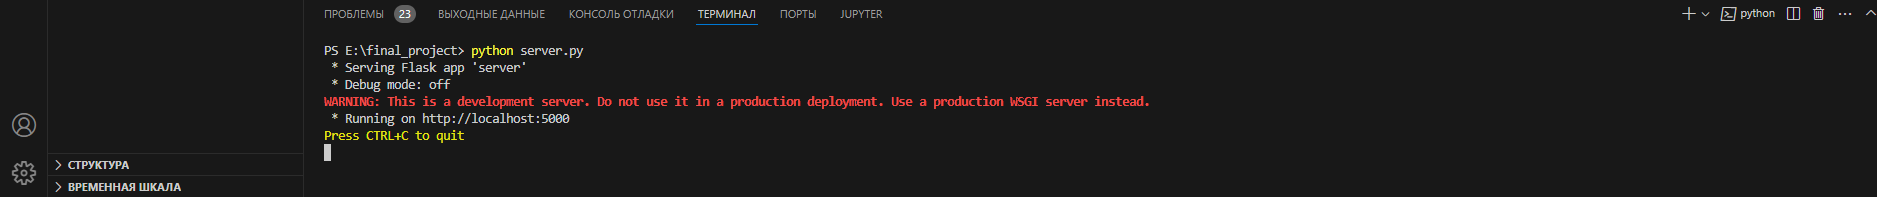
##### Далее запускаем клиента <i>client.py</i> также в терминале, параллельно работающему серверу, с помощью команды <i>python client.py</i>
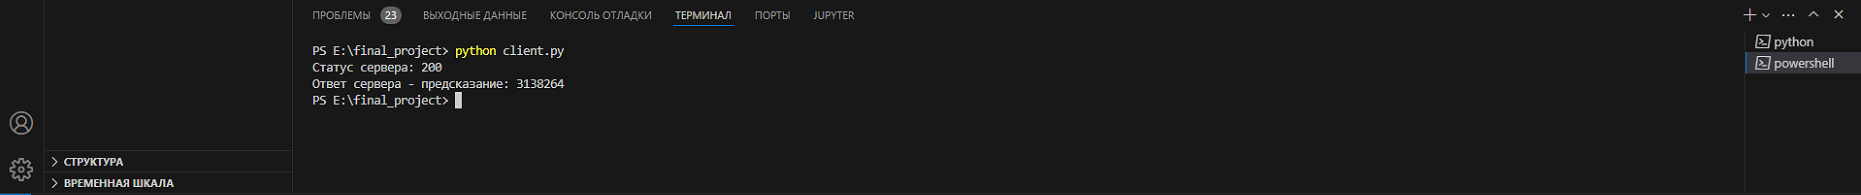
##### Как видим ответы совпадают, значит модель работает корректно. Останавливаем работу сервера сочетанием клавиш Ctrl+C.

##### <center><b>Выводы по проекту</b></center>
##### На протяжении проекта мы прошли через все этапы модели CRISP-DM, включая подготовку модели к продакшену. Все стоявшие перед нами задачи, выполнены. Проект можно считать успешно завершенным.
##### В качестве возможных шагов повышения качества моделирования, можно было бы отметить более пристальное внимание подготовке данных, например:
* разделить на большее количество категорий типы недвижимости;
* выделить ценовые категории недвижимости;
* применить алгоритмы кластеризации для выделения групп жилья по иным критериям;
* добавить в датафрейм новые данные в том числе на основании признака "street" (близость магазинов, автозаправок, мест развлечений; шумных автострад, аэропортов, вредных производств и т.д.).  
##### Также можно применить не задействованные алгоритмы и методы обработки данных, а также другие модели машинного обучения, включая нейронные сети.
##### В целом проект позволил применить все знания и навыки, полученные в курсе и благодаря своей сложности показал направления дальнейшего развития в области Data Science.